## This is a notebook to train a Bayesian neural network with variational inference.

Bayesian neural networks can quantify uncertainties in their prediction. In this notebook a Bayesian neural network is trained with variation inference to learn the function $$ y = 0.4 \sin(4x) + 0.5 \cos(12x) $$
A zero mean Gaussian random noise with standard deviation $\sigma = 0.05$ is added to the train data. Both the aleatoric (noise in the data) and the epistemic (model uncertainty) uncertaintes are quantified.

### Import necessary tools
This notebook uses [UQpy](https://uqpyproject.readthedocs.io/en/latest/) which is a general purpose python toolbox for uncertainty quantification. In the following cell we import the necessary libraries to set up the environment to run the code.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# UQpy imports
from UQpy.scientific_machine_learning.layers import BayesianLayer
from UQpy.scientific_machine_learning.neural_networks import FeedForwardNeuralNetwork
from UQpy.scientific_machine_learning.trainers import BBBTrainer

import logging

logger = logging.getLogger("UQpy")
logger.setLevel(logging.INFO)

torch.manual_seed(0);
np.random.seed(0);

### Build the Neural Network
Once the libraries are loaded, we build the neural network. The neural network consists of 3 hidden layers with ReLu activation function. The `width` of these hidden layers can be prescribed by the user.

In [2]:
width = 20
network = nn.Sequential(
    BayesianLayer(1, width),
    nn.ReLU(),
    BayesianLayer(width, width),
    nn.ReLU(),
    BayesianLayer(width, width),
    nn.ReLU(),
    BayesianLayer(width, width),
    nn.ReLU(),
    BayesianLayer(width, 1),
)
model = FeedForwardNeuralNetwork(network)

### Define the data
Now, we define the dataset and the data loader. The dataset class takes the number of samples and the standard deviation of the noise parameter as the input to produce x,y pairs of training data. This class is given as an input to the pytorch DataLoader. 

In [3]:
class SinusoidalDataset(Dataset):
    def __init__(self, n_samples=20, noise_std=0.05):
        self.n_samples = n_samples
        self.noise_std = noise_std
        self.x = torch.cat((torch.linspace(-1, -0.2, int(n_samples/2)),torch.linspace(0.2, 1, int(n_samples/2)))).reshape(-1, 1)
        self.y = torch.tensor(0.4 * np.sin(4 * self.x) + 0.5 * np.cos(12 * self.x) +
                              np.random.normal(0, self.noise_std, self.x.shape), dtype=torch.float)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, item):
        return self.x[item], self.y[item]

train_data = DataLoader(SinusoidalDataset(), batch_size=20, shuffle=True)

### Train the model
We define the optimizer with the parameters such as the learning rate and call the Bayes By Backprop Trainer implemented in UQpy to learn the parameters of the model.

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = BBBTrainer(model, optimizer)

Here, we train the model upto a user specified epoch. `beta` is the KL weighting parameter of the ELBO loss and `num_samples` is the number of Monte carlo samples to approximate the log likehood of the data in the ELBO loss. For convenience, the model as already been trained and its weights saved. The code below was used to train the model.

```python

print("Starting Training...", end="")
trainer.run(train_data=train_data, epochs=5000, beta=1e-6, num_samples=10)
print("done")

checkpt = {'model':model.state_dict(),
            'Train_loss':train_loss,    
            }
torch.save(checkpt, 'VI_results.pt')
train_loss = trainer.history["train_loss"].detach().numpy()

### Make predictions and visualize the results
We load the previously trained model to make predictions.

In [5]:
ckpt = torch.load('VI_results.pt')
model.load_state_dict(ckpt['model'])
train_loss = ckpt['Train_loss']

We perdict the outputs for the test examples using the trained model. model.train(False) and model.sample(False) ensures that the mean of the parameters are used for predicting the outputs. When one of these is True, samples are drawn from the distribution of the parameters to make predictions. 

In [6]:
# Plotting Results
x = SinusoidalDataset().x
y = SinusoidalDataset().y
x_val = torch.linspace(-1, 1, 1000).view(-1,1)
y_val = (0.4 * torch.sin(4 * x_val) + 0.5 * torch.cos(12 * x_val))
model.train(False)
model.sample(False);

We visualize the predictions using the following plots. Here the prediction is made using the mean of the parameters

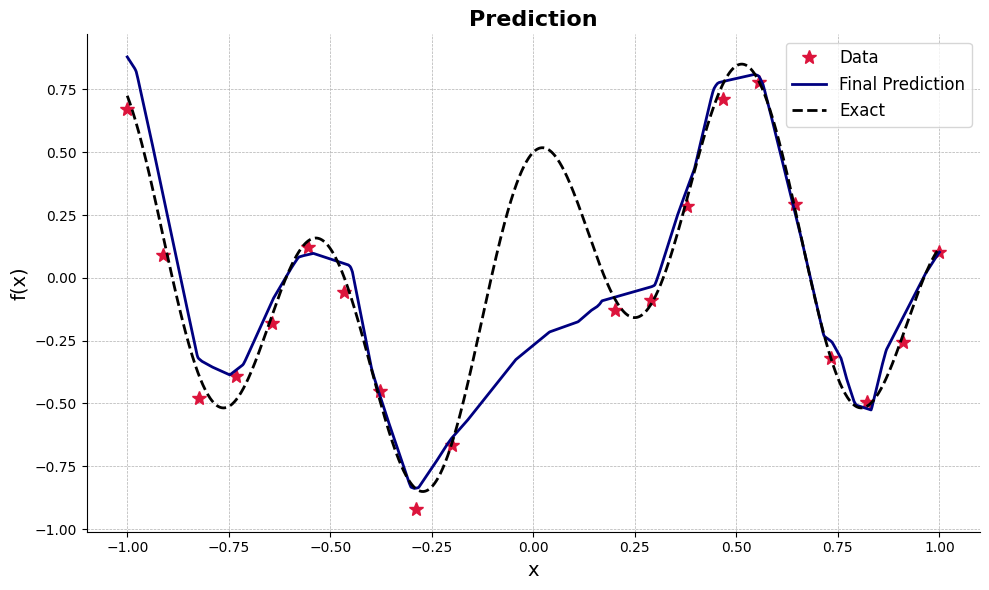

In [7]:
pred_val = model(x_val)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    x.detach().numpy(),
    y.detach().numpy(), '*',
    label="Data", color='crimson', markersize=10
)
ax.plot(
    x_val.detach().numpy(),
    pred_val.detach().numpy(),
    label="Final Prediction",
    color='navy', linewidth=2
)
ax.plot(
    x_val.detach(), y_val.detach(),
    label="Exact",
    color="black",
    linestyle="dashed",
    linewidth=2
)

# Customize the plot
ax.set_title("Prediction", fontsize=16, fontweight='bold')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("f(x)", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

Convergence of the loss function is shown in the following.

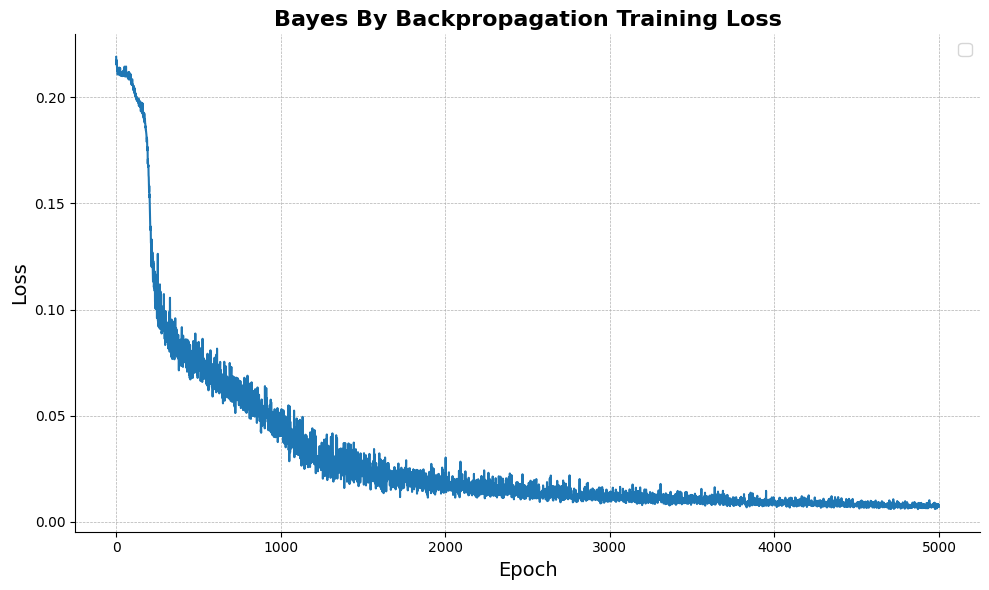

In [8]:

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_loss)


# Customize the plot
ax.set_title("Bayes By Backpropagation Training Loss", fontsize=16, fontweight='bold')
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Improve the layout
plt.tight_layout()
plt.show()

We perform uncertainty quantification by sampling the parameters of the model $n$ times and predicting the output for each of these sample parameters. The variance in the prediction gives us measure of epistemic uncertianty. The total uncertainty 
$$ \sigma_{total}^2 = \sigma_{epistemic}^2 + \sigma_{aleatoric}^2 $$

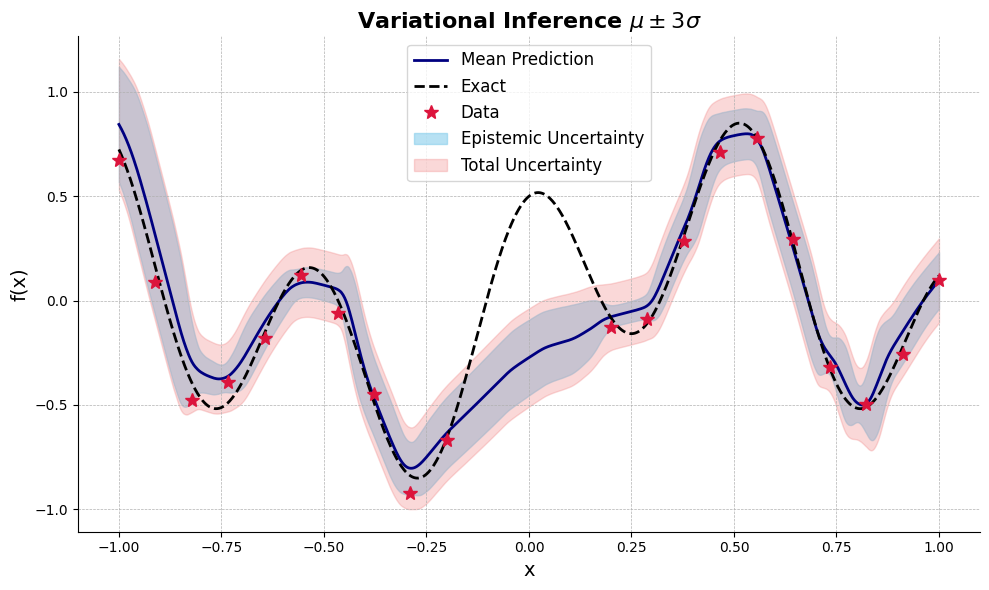

In [9]:
model.sample(True)
n = 100
samples = torch.zeros(len(x_val), n)
for i in range(n):
    samples[:, i] = model(x_val).squeeze()

mean_pred = torch.mean(samples, dim=1)
variance = torch.var(samples, dim=1)
standard_deviation = torch.sqrt(variance)

x_plot = x.squeeze().detach().numpy()
mu = mean_pred.squeeze().detach().numpy()
sigma = standard_deviation.squeeze().detach().numpy()
total_sigma = np.sqrt(sigma**2 + 0.05**2)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean prediction
ax.plot(x_val, mu, label="Mean Prediction", color='navy', linewidth=2)

#Plot the true function
ax.plot(
    x_val.detach(), y_val.detach(),
    label="Exact",
    color="black",
    linestyle="dashed",
    linewidth=2
)
# Plot the data points
ax.plot(
    x.detach().numpy(),
    y.detach().numpy(), '*',
    label="Data", color='crimson', markersize=10
)

# Fill the uncertainties
ax.fill_between(
    x_val.view(-1).detach(), mu - (3 * sigma), mu + (3 * sigma), 
    label="Epistemic Uncertainty", color='skyblue', alpha=0.6
)
ax.fill_between(
    x_val.view(-1).detach(), mu - (3 * total_sigma), mu + (3 * total_sigma), 
    label="Total Uncertainty", color='lightcoral', alpha=0.3
)

# Customize the plot
ax.set_title("Variational Inference $\mu \pm 3\sigma$", fontsize=16, fontweight='bold')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("f(x)", fontsize=14)
ax.legend(loc='upper center', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Improve the layout
plt.tight_layout()
plt.savefig('VI_bnn.png')
# Show the plot
plt.show()